# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [4]:
## define SPARQL enpoint
endpoint = "https://ag1wswatzl7f0n2y.allegrograph.cloud/repositories/As-de-la-Guerre"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX franzOption_serviceTimeout: <franz:120>

SELECT ?s 
       (MAX(?label) AS ?label) 
       (xsd:integer(MAX(?birthYear)) AS ?birthYear) 
       (xsd:integer(MAX(?deathYear)) AS ?deathYear) 
       (MAX(?countryLabel) AS ?countryLabel)
       (MAX(?country) AS ?countryUri)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {
    ?s rdfs:label ?label ;
       wdt:P569 ?birthYear .

    OPTIONAL { ?s wdt:P570 ?deathYear. }
    OPTIONAL { 
      ?s wdt:P27 ?country .
      ?country rdfs:label ?countryLabel .
    }
  }
}
GROUP BY ?s
ORDER BY ?birthYear


"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

1070


[['http://www.wikidata.org/entity/Q63683421',
  'Fritz W. Hammer',
  '1801',
  '1938',
  'German Reich',
  'http://www.wikidata.org/entity/Q1206012'],
 ['http://www.wikidata.org/entity/Q6225085',
  'John Capper',
  '1861',
  '1955',
  'United Kingdom of Great Britain and Ireland',
  'http://www.wikidata.org/entity/Q174193'],
 ['http://www.wikidata.org/entity/Q3724015',
  'Emanuele Vittorio Parodi',
  '1862',
  '1945',
  'Kingdom of Italy',
  'http://www.wikidata.org/entity/Q172579']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'deathYear', 'countryLabel', 'countryUri']
df_p.head()

,personUri,personLabel,birthYear,deathYear,countryLabel,countryUri
0,http://www.wikidata.org/entity/Q63683421,Fritz W. Hammer,1801,1938,German Reich,http://www.wikidata.org/entity/Q1206012
1,http://www.wikidata.org/entity/Q6225085,John Capper,1861,1955,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q174193
2,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,1862,1945,Kingdom of Italy,http://www.wikidata.org/entity/Q172579
3,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,1862,1929,Germany,http://www.wikidata.org/entity/Q183
4,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,1863,1938,Kingdom of Italy,http://www.wikidata.org/entity/Q172579


In [9]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   personUri     1070 non-null   object
 1   personLabel   1070 non-null   object
 2   birthYear     1070 non-null   object
 3   deathYear     1070 non-null   object
 4   countryLabel  1070 non-null   object
 5   countryUri    1070 non-null   object
dtypes: object(6)
memory usage: 50.3+ KB


### Vérifier les nationalités présentes directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec le code de la nationalité 

In [10]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'c_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_country(c_uri):
    if c_uri == 'http://www.wikidata.org/entity/Q145':
        # UK
        a = 'UK'
    elif c_uri == 'http://www.wikidata.org/entity/Q142':
        # France
        a = 'FR'
    elif c_uri == 'http://www.wikidata.org/entity/Q183':
        # Allemagne
        a = 'DE'
    else:
        # country autre
        a = 'A'
    return a    

In [11]:
### On teste la fonction (Q38 = Italy)
print(code_country('http://www.wikidata.org/entity/Q38'))

A


In [12]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['countryCode'] = df_p.apply(lambda x: code_country(x['countryUri']), axis=1)

In [13]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['countryCode']=='A'][:5]

,personUri,personLabel,birthYear,deathYear,countryLabel,countryUri,countryCode
0,http://www.wikidata.org/entity/Q63683421,Fritz W. Hammer,1801,1938,German Reich,http://www.wikidata.org/entity/Q1206012,A
1,http://www.wikidata.org/entity/Q6225085,John Capper,1861,1955,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q174193,A
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,1863,1938,Kingdom of Italy,http://www.wikidata.org/entity/Q172579,A
5,http://www.wikidata.org/entity/Q5132863,Clifford B. Harmon,1866,1945,United States,http://www.wikidata.org/entity/Q30,A
6,http://www.wikidata.org/entity/Q2151021,Richard Kehler,1866,1943,German Reich,http://www.wikidata.org/entity/Q1206012,A


## Effectifs par année

In [14]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1066 entries, 0 to 1065
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
1066 non-null   object
dtypes: object(1)
memory usage: 8.5+ KB


In [15]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [16]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 200
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1801,1
1,1861,1
2,1862,1
3,1863,1
4,1865,1
5,1866,2
6,1867,2
7,1868,2
8,1869,2
9,1870,2


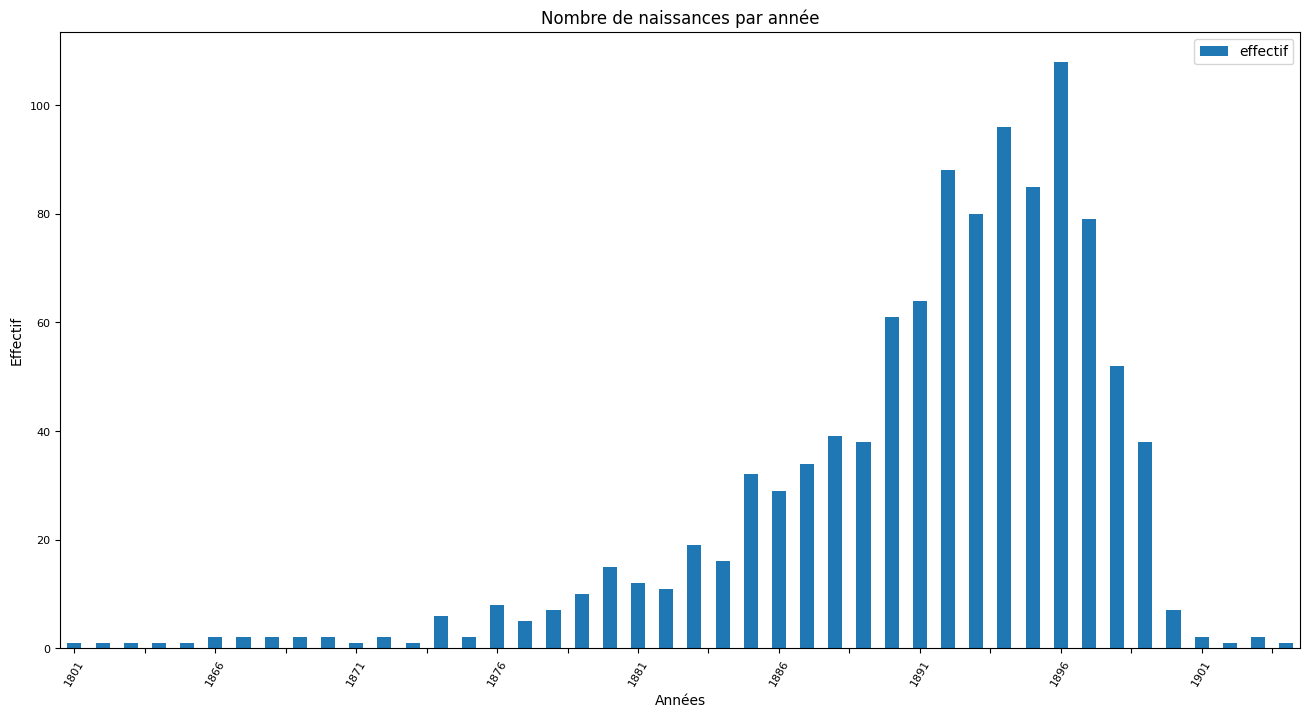

In [17]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 25 ans

In [18]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [19]:
cdf_p.head(3)

,personUri,personLabel,birthYear,deathYear,countryLabel,countryUri,countryCode
0,http://www.wikidata.org/entity/Q63683421,Fritz W. Hammer,1801,1938,German Reich,http://www.wikidata.org/entity/Q1206012,A
1,http://www.wikidata.org/entity/Q6225085,John Capper,1861,1955,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q174193,A
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,1862,1929,Germany,http://www.wikidata.org/entity/Q183,DE


In [20]:
### Année minimale et maximale dans la population
print(min(cdf_p['birthYear']), max(cdf_p['birthYear']))

1801 1904


### Codage par période de cinq ans

In [21]:
### Créer une liste d'années pour séparer en périodes de 5 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_5 = list(range(1800, 1905, 5))
print(l_5[:5],l_5[-5:])

[1800, 1805, 1810, 1815, 1820] [1880, 1885, 1890, 1895, 1900]


In [22]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_5, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,deathYear,countryLabel,countryUri,countryCode,periodes
0,http://www.wikidata.org/entity/Q63683421,Fritz W. Hammer,1801,1938,German Reich,http://www.wikidata.org/entity/Q1206012,A,1800-1804
1,http://www.wikidata.org/entity/Q6225085,John Capper,1861,1955,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q174193,A,1860-1864
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,1862,1929,Germany,http://www.wikidata.org/entity/Q183,DE,1860-1864


In [23]:
### compter les naissances par périodes de 5 ans
cdf_p.groupby(by='periodes').size()

C:\Users\menou\AppData\Local\Temp\ipykernel_12576\1755115692.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf_p.groupby(by='periodes').size()


periodes
1800-1804      1
1805-1809      0
1810-1814      0
1815-1819      0
1820-1824      0
1825-1829      0
1830-1834      0
1835-1839      0
1840-1844      0
1845-1849      0
1850-1854      0
1855-1859      0
1860-1864      3
1865-1869      9
1870-1874     12
1875-1879     32
1880-1884     73
1885-1889    172
1890-1894    389
1895-1899    362
dtype: int64

C:\Users\menou\AppData\Local\Temp\ipykernel_12576\3694462858.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


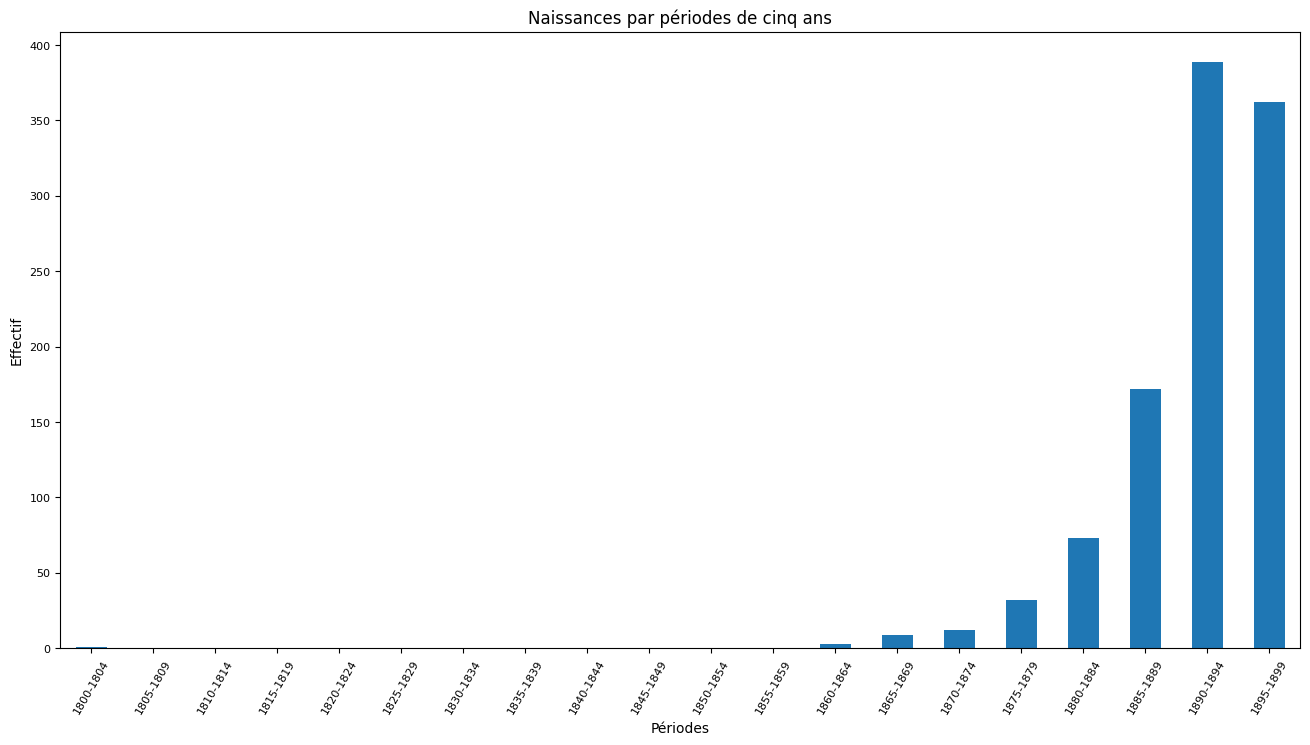

In [24]:
ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinq ans')
plt.show()

## Ajouter la représentation des nationalités

In [25]:
### Regrouper et compter avec un fitre sur la nationalité française (FR)
country_fr = pd.DataFrame(cdf_p[cdf_p['countryCode'] == 'FR'].groupby('periodes').size())
country_fr.columns = ['country_fr']
country_fr.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_12576\19084893.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fr = pd.DataFrame(cdf_p[cdf_p['countryCode'] == 'FR'].groupby('periodes').size())


,country_fr
periodes,
1875-1879,15
1880-1884,29
1885-1889,46
1890-1894,88
1895-1899,58


In [26]:
### Regrouper et compter avec les autres
countrynot_fr = pd.DataFrame(cdf_p[cdf_p['countryCode'] != 'FR'].groupby('periodes').size())
countrynot_fr.columns = ['countrynot_fr']
countrynot_fr.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_12576\4024875682.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  countrynot_fr = pd.DataFrame(cdf_p[cdf_p['countryCode'] != 'FR'].groupby('periodes').size())


,countrynot_fr
periodes,
1875-1879,17
1880-1884,44
1885-1889,126
1890-1894,301
1895-1899,304


In [27]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(country_fr, countrynot_fr, left_index=True, right_index=True)
merged.tail()

,country_fr,countrynot_fr
periodes,,
1875-1879,15,17
1880-1884,29,44
1885-1889,46,126
1890-1894,88,301
1895-1899,58,304


In [28]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,country_fr,countrynot_fr
periodes,,
1875-1879,15,17
1880-1884,29,44
1885-1889,46,126
1890-1894,88,301
1895-1899,58,304


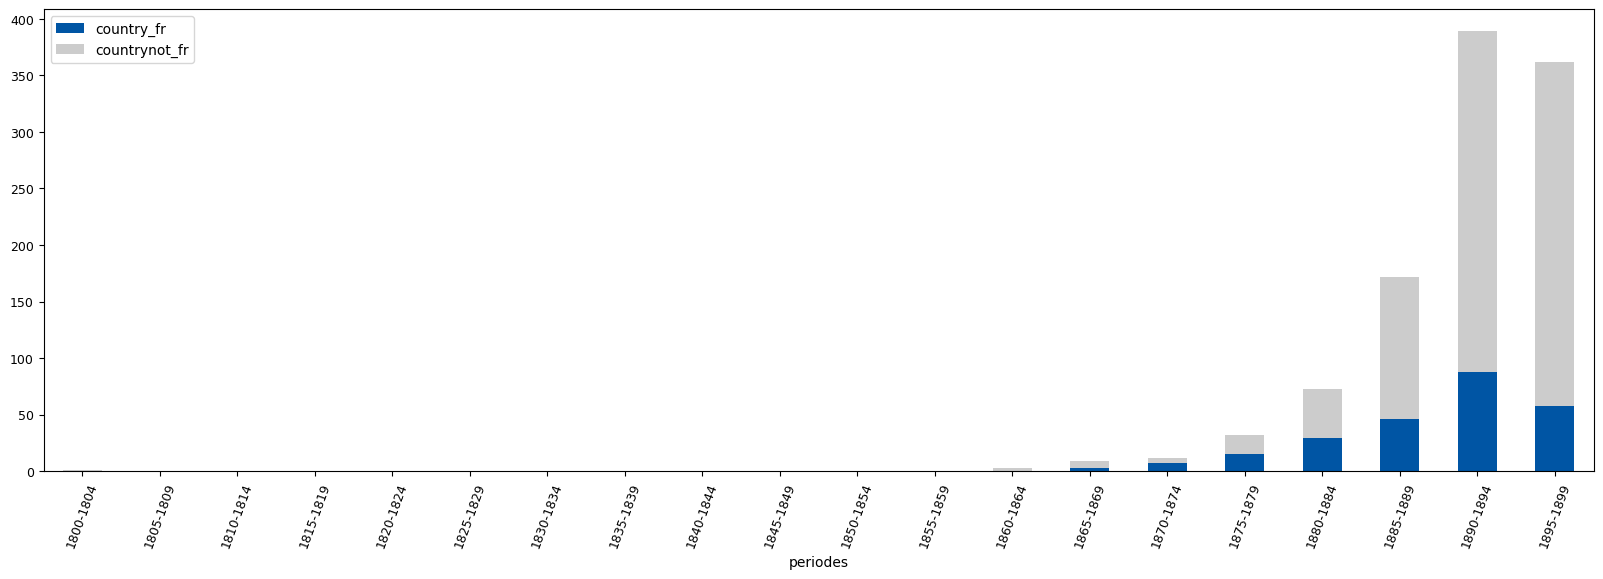

In [29]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['#0055A4', '#CCCCCC'])
plt.show()

### Codage par période de deux ans

Comme on voit bien dans le graphique précédent qu'il y a une période avec des effectifs importants, 
on restraint la période analysée et on affine avec un découpage par périodes de deux ans 

In [30]:
l_2 = list(range(1880, 1900, 2))
print(l_2[:5],l_2[-5:])

[1880, 1882, 1884, 1886, 1888] [1890, 1892, 1894, 1896, 1898]


In [31]:
### Découpage tous les deux ans
# fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_2'] = pd.cut(cdf_p['birthYear'], l_2, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_2'] = cdf_p['per_2'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,deathYear,countryLabel,countryUri,countryCode,periodes,per_2
0,http://www.wikidata.org/entity/Q63683421,Fritz W. Hammer,1801,1938,German Reich,http://www.wikidata.org/entity/Q1206012,A,1800-1804,NaN
1,http://www.wikidata.org/entity/Q6225085,John Capper,1861,1955,United Kingdom of Great Britain and Ireland,http://www.wikidata.org/entity/Q174193,A,1860-1864,NaN
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,1862,1929,Germany,http://www.wikidata.org/entity/Q183,DE,1860-1864,NaN


In [34]:
### On regroupe par nationalité comme ci-dessus

country_fr_2 = pd.DataFrame(cdf_p[(cdf_p.countryCode == 'FR') & (cdf_p.birthYear > 1850)].groupby('per_2').size())
country_fr_2.columns = ['country_fr']
country_fr_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_12576\1374231519.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fr_2 = pd.DataFrame(cdf_p[(cdf_p.countryCode == 'FR') & (cdf_p.birthYear > 1850)].groupby('per_2').size())


,country_fr
per_2,
1888-1889,26
1890-1891,31
1892-1893,34
1894-1895,38
1896-1897,29


In [35]:
### Idem
countrynot_fr_2 = pd.DataFrame(cdf_p[(cdf_p.countryCode != 'FR')& (cdf_p.birthYear > 1850)].groupby('per_2').size())
countrynot_fr_2.columns = ['countrynot_fr']
countrynot_fr_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_12576\3858206883.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  countrynot_fr_2 = pd.DataFrame(cdf_p[(cdf_p.countryCode != 'FR')& (cdf_p.birthYear > 1850)].groupby('per_2').size())


,countrynot_fr
per_2,
1888-1889,51
1890-1891,94
1892-1893,134
1894-1895,143
1896-1897,158


In [36]:
merged_2 = pd.merge(country_fr_2, countrynot_fr_2, left_index=True, right_index=True)
merged_2.tail()

,country_fr,countrynot_fr
per_2,,
1888-1889,26,51
1890-1891,31,94
1892-1893,34,134
1894-1895,38,143
1896-1897,29,158


In [37]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_2.index = merged_2.index.map(str)
merged_2['tot']=merged_2['country_fr']+merged_2['countrynot_fr']
merged_2.tail()

,country_fr,countrynot_fr,tot
per_2,,,
1888-1889,26,51,77
1890-1891,31,94,125
1892-1893,34,134,168
1894-1895,38,143,181
1896-1897,29,158,187


In [41]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
fr_notfr = merged_2.country_fr.to_list() + merged_2.countrynot_fr.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_2.tot.to_list() * 2

# liste qui contient les valeurs des fréquences
lp = [round(v / t, 2) for v, t in zip(fr_notfr, tot)]

lp[:3]

[0.37, 0.4, 0.25]

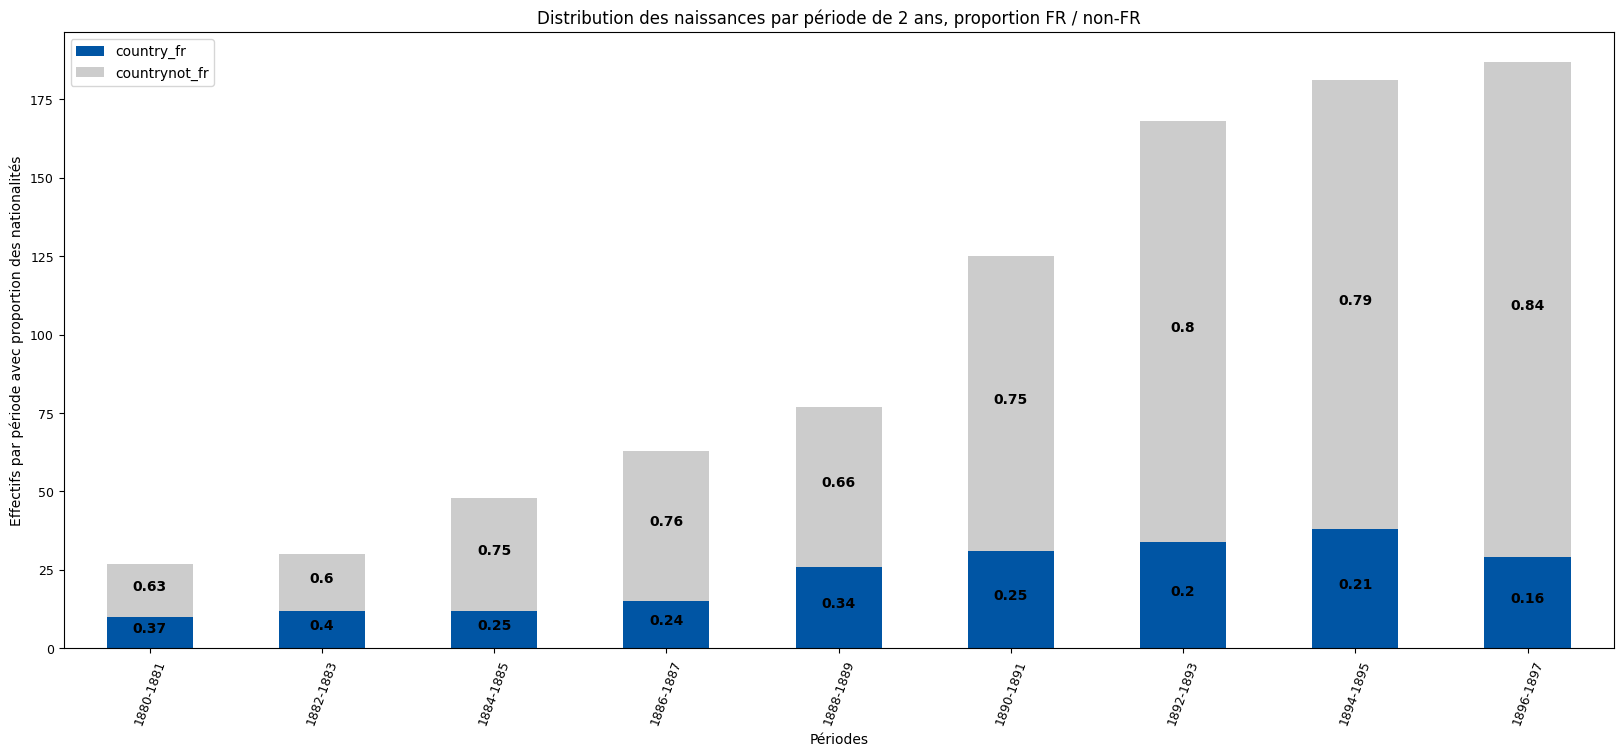

In [45]:
### Graphique avec la distribution par période et pays (FR, non-FR)
# On n'affiche que les pays 'FR' et 'non-FR', donc à 2 modalités

ax = merged_2.plot.bar(
    stacked=True,
    y=['country_fr', 'countrynot_fr'],
    rot=70,
    fontsize=9,
    figsize=(20, 8),
    color=['#0055A4', '#CCCCCC']
)

## Ajout des étiquettes de proportions sur les barres
for bar, v in zip(ax.patches, lp): 
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2 + bar.get_y(),
        v,
        ha='center',
        color='black',
        weight='bold',
        size=10
    )

plt.ylabel('Effectifs par période avec proportion des nationalités')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par période de 2 ans, proportion FR / non-FR')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('naissances_distribution_2ans_pays.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()